In [32]:
from sklearn.datasets import make_moons, load_iris
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    BaggingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    StackingClassifier
)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

import matplotlib.pyplot as plt
import numpy as np


# Voting Classifiers


In [2]:
X, y = make_moons(n_samples=500, noise=0.3, random_state=23)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)


In [3]:
voting_clf = VotingClassifier(
    estimators=[
        ("lr", LogisticRegression(random_state=42)),
        ("rf", RandomForestClassifier(random_state=42)),
        ("svc", SVC(random_state=42)),
    ]
)

voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [4]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))


lr = 0.784
rf = 0.912
svc = 0.888


In [5]:
voting_clf.predict(X_test[:1])


array([1])

In [6]:
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]


[array([1]), array([0]), array([1])]

In [7]:
voting_clf.score(X_test, y_test)


0.88

If all classifiers are able to estimate class probabilities (i.e., if they all have a
predict_proba() method), then you can tell Scikit-Learn to predict the class with
the highest class probability, averaged over all the individual classifiers. This is called
soft voting. It often achieves higher performance than hard voting because it gives
more weight to highly confident votes. All you need to do is set the voting classifier’s
voting hyperparameter to "soft", and ensure that all classifiers can estimate class
probabilities. This is not the case for the SVC class by default, so you need to set its
probability hyperparameter to True (this will make the SVC class use crossvalidation to estimate class probabilities, slowing down training, and it will add a
predict_proba() method). Let’s try that:


In [8]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)


0.872

# Bagging and Pasting


#### Bagging = with replacement (bootstrap=True)

#### Pasting = withount replacement (bootstrap=False)

#### n_job = number of CPU cores used for training. -1 = all available cores


In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    n_jobs=-1,
    random_state=34,
)
bag_clf.fit(X_train, y_train)


BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=34)

In [10]:
paste_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    n_jobs=-1,
    random_state=34,
    bootstrap=False,
)
paste_clf.fit(X_train, y_train)


BaggingClassifier(bootstrap=False, estimator=DecisionTreeClassifier(),
                  max_samples=100, n_estimators=500, n_jobs=-1,
                  random_state=34)

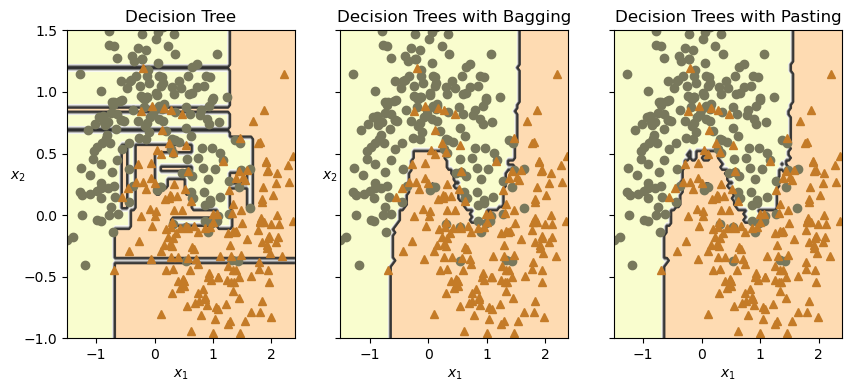

In [11]:
# extra code – this cell generates and saves Figure 7–5


def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes = [-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(
        np.linspace(axes[0], axes[1], 100), np.linspace(axes[2], axes[3], 100)
    )
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap="Wistia")
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(
            X[:, 0][y == idx],
            X[:, 1][y == idx],
            color=colors[idx],
            marker=markers[idx],
            linestyle="none",
        )
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)


tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=3, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.sca(axes[2])
plot_decision_boundary(paste_clf, X_train, y_train)
plt.title("Decision Trees with Pasting")
plt.ylabel("")
# save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()


In [12]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    n_jobs=-1,
    random_state=34,
    bootstrap=True,
    oob_score=True,
)
bag_clf.fit(X_train, y_train)

bag_clf.oob_score_


0.8666666666666667

In [13]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)


0.912

In [14]:
y_pred = paste_clf.predict(X_test)
accuracy_score(y_test, y_pred)


0.928

In [15]:
bag_clf.oob_decision_function_[:5]


array([[0.86923077, 0.13076923],
       [0.10539846, 0.89460154],
       [0.96153846, 0.03846154],
       [0.03350515, 0.96649485],
       [0.35106383, 0.64893617]])

# Random Forests


In [16]:
rnd_clf = RandomForestClassifier(
    n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=3
)
rnd_clf.fit(X_train, y_train)

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)


0.896

In [17]:
from regex import splititer


bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random"),
    n_estimators=500,
    max_samples=100,
    n_jobs=-1,
    random_state=34,
    bootstrap=True,
    oob_score=True,
)
bag_clf.fit(X_train, y_train)

bag_clf.oob_score_


0.8666666666666667

In [18]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)


0.912

## Extra Random Forrests


In [19]:
ext_clf = ExtraTreesClassifier(
    n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=34
)
ext_clf.fit(X_test, y_test)

y_pred = ext_clf.predict(X_test)
accuracy_score(y_test, y_pred)


0.944

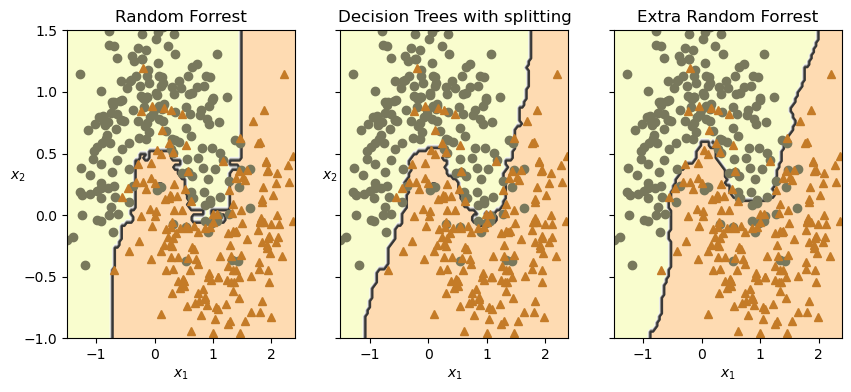

In [20]:
# extra code – this cell generates and saves Figure 7–5


def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes = [-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(
        np.linspace(axes[0], axes[1], 100), np.linspace(axes[2], axes[3], 100)
    )
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap="Wistia")
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(
            X[:, 0][y == idx],
            X[:, 1][y == idx],
            color=colors[idx],
            marker=markers[idx],
            linestyle="none",
        )
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)


fig, axes = plt.subplots(ncols=3, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(rnd_clf, X_train, y_train)
plt.title("Random Forrest")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with splitting")
plt.sca(axes[2])
plot_decision_boundary(ext_clf, X_train, y_train)
plt.title("Extra Random Forrest")
plt.ylabel("")
# save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()


## Feature Imoprtance


In [21]:
iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=2)
rnd_clf.fit(iris.data, iris.target)

for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(score, name)


0.10120111084260197 sepal length (cm)
0.023486857680372362 sepal width (cm)
0.4207876271186054 petal length (cm)
0.4545244043584204 petal width (cm)


In [22]:
iris.data[:5]


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


# Boosting


## AdaBoosting


In [23]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    learning_rate=0.5,
    random_state=43,
)
ada_clf.fit(X_train, y_train)


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, random_state=43)

## Gradient Boosting


In [24]:
np.random.seed(34)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x2 + Gaussian noise

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=3).fit(X, y)

y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=3).fit(X, y2)

y3 = y - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=3).fit(X, y3)


In [25]:
X_new = np.array([[-0.4], [0.0], [0.5]])
sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))


array([0.99695011, 0.22835002, 1.04184901])

In [26]:
gbrt = GradientBoostingRegressor(
    max_depth=2, n_estimators=3, learning_rate=1.0, random_state=3
).fit(X, y)


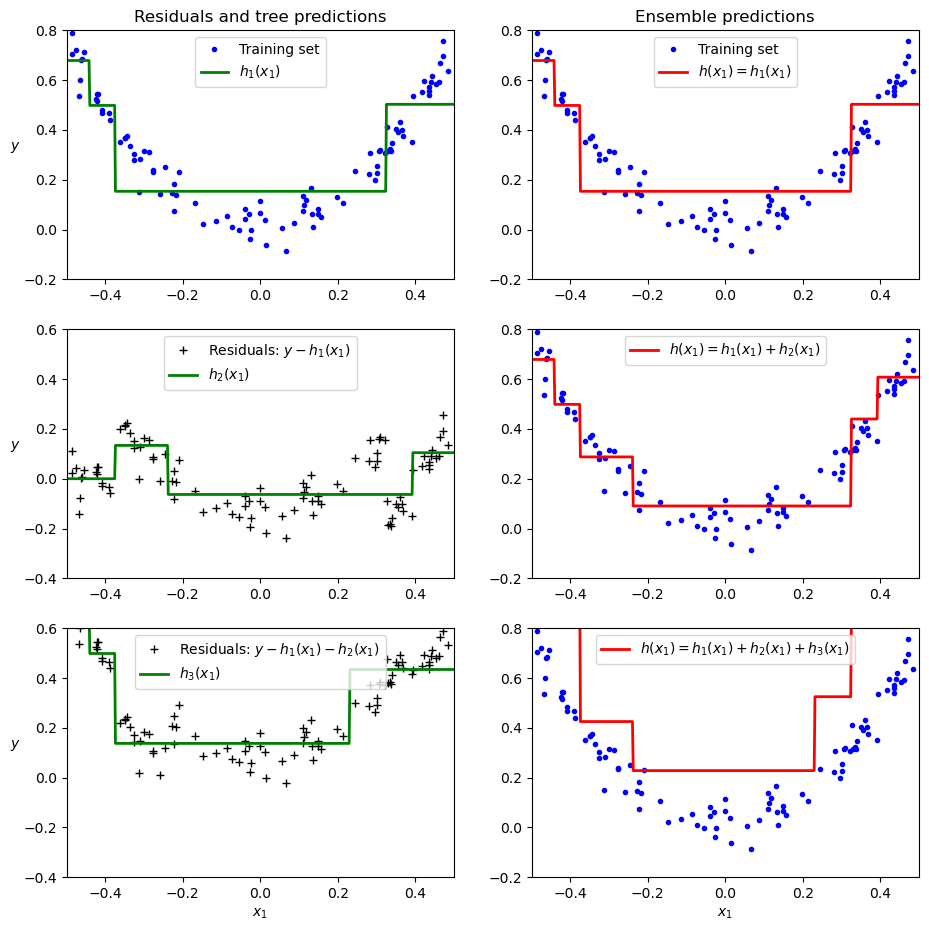

In [27]:
# extra code – this cell generates and saves Figure 7–9


def plot_predictions(
    regressors, X, y, axes, style, label=None, data_style="b.", data_label=None
):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)


plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions(
    [tree_reg1],
    X,
    y,
    axes=[-0.5, 0.5, -0.2, 0.8],
    style="g-",
    label="$h_1(x_1)$",
    data_label="Training set",
)
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions(
    [tree_reg1],
    X,
    y,
    axes=[-0.5, 0.5, -0.2, 0.8],
    style="r-",
    label="$h(x_1) = h_1(x_1)$",
    data_label="Training set",
)
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions(
    [tree_reg2],
    X,
    y2,
    axes=[-0.5, 0.5, -0.4, 0.6],
    style="g-",
    label="$h_2(x_1)$",
    data_style="k+",
    data_label="Residuals: $y - h_1(x_1)$",
)
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions(
    [tree_reg1, tree_reg2],
    X,
    y,
    axes=[-0.5, 0.5, -0.2, 0.8],
    style="r-",
    label="$h(x_1) = h_1(x_1) + h_2(x_1)$",
)

plt.subplot(3, 2, 5)
plot_predictions(
    [tree_reg3],
    X,
    y3,
    axes=[-0.5, 0.5, -0.4, 0.6],
    style="g-",
    label="$h_3(x_1)$",
    data_style="k+",
    data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$",
)
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions(
    [tree_reg1, tree_reg2, tree_reg3],
    X,
    y,
    axes=[-0.5, 0.5, -0.2, 0.8],
    style="r-",
    label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$",
)
plt.xlabel("$x_1$")
plt.show()


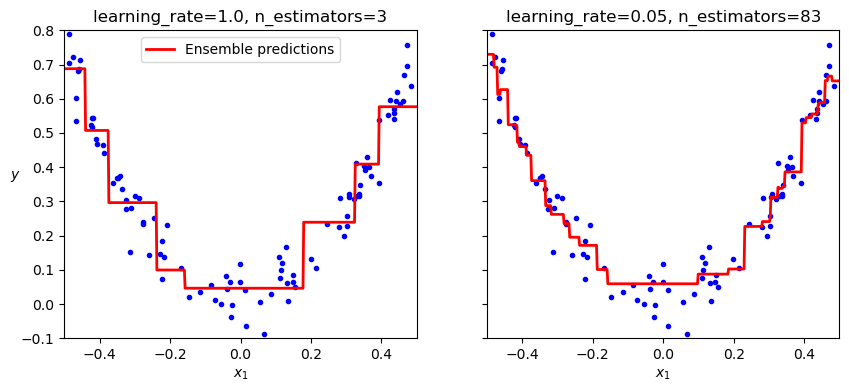

In [28]:
# extra code – this cell generates and saves Figure 7–10
gbrt_best = GradientBoostingRegressor(
    max_depth=2,
    learning_rate=0.05,
    n_estimators=500,
    n_iter_no_change=10,
    random_state=42,
)
gbrt_best.fit(X, y)
gbrt_best.n_estimators_

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(
    [gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-", label="Ensemble predictions"
)
plt.title(f"learning_rate={gbrt.learning_rate}, " f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(
    f"learning_rate={gbrt_best.learning_rate}, "
    f"n_estimators={gbrt_best.n_estimators_}"
)
plt.xlabel("$x_1$")


plt.show()


In [29]:
gbrt_best = GradientBoostingRegressor(
    max_depth=2,
    learning_rate=0.09,
    n_estimators=500,
    n_iter_no_change=10,
    random_state=234,
).fit(X, y)
gbrt_best.n_estimators_


63

The GradientBoostingRegressor class also supports a subsample hyperparameter, which specifies the fraction of training instances to be used for training each tree. For example, if subsample=0.25, then each tree is trained on 25% of the training instances, selected randomly. As you can probably guess by now, this technique trades a higher bias for a lower variance. It also speeds up training considerably. This is called stochastic gradient boosting.


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tarfile
import urllib.request
from pathlib import Path


def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))


housing = load_housing_data()

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
housing_labels = train_set["median_house_value"]
housing = train_set.drop("median_house_value", axis=1)


In [31]:
hgb_reg = make_pipeline(
    make_column_transformer(
        (OrdinalEncoder(), ["ocean_proximity"]), remainder="passthrough"
    ),
    HistGradientBoostingRegressor(categorical_features=[0], random_state=234),
).fit(housing, housing_labels)


# Stacking

In [33]:
stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=3)),
        ('rf', RandomForestClassifier(random_state=3)),
        ('svc', SVC(random_state=4))
    ],
    final_estimator=RandomForestClassifier(random_state=3),
    cv=10
).fit(X_train, y_train)